In [145]:
#pandas libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.model_selection as modsel
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math
import statistics

%run "../notebooks/cargar_df.ipynb"

In [3]:
train = get_train()

In [4]:
test = get_test()

In [5]:
train = train[train.Stage.isin(['Closed Won', 'Closed Lost'])].copy()
train.shape

(16883, 47)

In [6]:
train.Stage.value_counts()

Closed Won     9533
Closed Lost    7350
Name: Stage, dtype: int64

In [7]:
# Me quedo con los registros con la oportunidad terminada
train.Stage.replace({'Closed Won': 1, 'Closed Lost': 0}, inplace=True)

In [8]:
train.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

In [9]:
X = pd.DataFrame({'Opportunity_ID':train.Opportunity_ID.unique()})

In [10]:
# Hago lo mismo con test
testX = pd.DataFrame({'Opportunity_ID':test.Opportunity_ID.unique()})

Busco registros que tengan la misma opportunity id para saber cuales son
las columnas que pueden cambiar el valor

In [11]:
b = train.groupby('Opportunity_ID').ID.count() > 1
b = b[b] # Dejo solo los trues
df = train[train.Opportunity_ID.isin(b.index)]
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
8,24353,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,15600.0,JPY,470400.0,0
9,24355,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,4400.0,JPY,470400.0,0
10,24356,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,6200.0,JPY,470400.0,0
11,24357,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,140000.0,JPY,470400.0,0
12,24358,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,304200.0,JPY,470400.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940,20827,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10751580.0,USD,21332500.0,0
16941,20830,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10580920.0,USD,21332500.0,0
16942,8781,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-03-25,2016-03-01,Q1,2016,0,EUR,103350.0,EUR,299715.0,1
16943,8786,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-04-08,2016-04-01,Q2,2016,0,EUR,93015.0,EUR,299715.0,1


In [12]:
print('Columnas que cambian de valor dependiendo de la Id en train')

size = df.Opportunity_ID.unique().size
diff_columns = []
for column in df.columns:
    if (df.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en train


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [13]:
print('Columnas que cambian de valor dependiendo de la Id en test')

size = test.Opportunity_ID.unique().size
diff_columns = []
for column in test.columns:
    if (test.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en test


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [14]:
# Junto el set de train y test en un nuevo data frame data
data = pd.concat([train.drop('Stage', axis=1), test])
data

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount
0,27761,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,...,2016-05-01,2016-06-30,2016-05-01,Q2,2016,10,EUR,5272800.0,EUR,5272800.0
1,27760,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,...,2016-01-18,2016-01-20,2016-01-01,Q1,2016,0,EUR,48230.0,EUR,48230.0
2,27446,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,...,2016-01-25,2016-01-25,2016-01-01,Q1,2016,0,USD,83865.6,USD,83865.6
3,16808,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,2018-02-01,2018-03-31,2018-02-01,Q1,2018,14,USD,7421881.5,USD,7421881.5
4,16805,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,2018-02-01,2018-02-28,2018-02-01,Q1,2018,25,USD,13357192.5,USD,13357192.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,16345,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,Source_3,...,2019-05-01,2019-05-10,2019-05-01,Q2,2019,0,USD,124740.0,USD,147750.0
2547,15218,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,None,...,2019-10-01,2019-12-31,2019-10-01,Q4,2019,0,USD,45054.9,USD,45054.9
2548,15224,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,None,...,2019-10-01,2019-12-31,2019-10-01,Q4,2019,0,USD,100122.0,USD,100122.0
2549,7286,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,None,...,2019-08-01,2019-08-01,2019-08-01,Q3,2019,0,USD,143220.0,USD,143220.0


In [15]:
grouped_data = data.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Pricing, Delivery_Terms_Quote_Appr':'first',
     'Pricing, Delivery_Terms_Approved':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Account_Created_Date':'first',
     'Source ':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Opportunity_Created_Date':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first',
     'Total_Taxable_Amount':'first'}).reset_index()
grouped_data

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount
0,0,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,...,None,None,None,1/30/2016,2016-06-13,Person_Name_18,EUR,EUR,EUR,5272800.0
1,1,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,...,None,None,None,1/20/2016,2016-01-15,Person_Name_20,EUR,EUR,EUR,48230.0
2,2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,...,None,None,None,9/30/2016,2016-09-29,Person_Name_8,USD,USD,USD,83865.6
3,3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,Product_Category_B_16,0.42,USD,NaT,2018-03-27,Person_Name_8,USD,USD,USD,7421881.5
4,4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,Product_Category_B_16,0.42,USD,6/2/2017,2018-03-27,Person_Name_8,USD,USD,USD,13357192.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,EMEA,Norway,1,1,0,0,Bureaucratic_Code_4,2013-07-27,Source_9,...,None,None,None,4/3/2016,2016-04-01,Person_Name_13,EUR,EUR,EUR,401700.0
11354,12800,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,None,None,None,1/15/2016,2016-10-10,Person_Name_13,USD,USD,USD,21332500.0
11355,12801,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,None,None,None,NaT,2016-01-19,Person_Name_13,EUR,EUR,EUR,299715.0
11356,12802,Americas,NE America,1,1,1,1,Bureaucratic_Code_4,2015-10-20,None,...,None,None,None,2/29/2016,2016-01-22,Person_Name_3,USD,USD,USD,0.0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 16946
Data columns (total 47 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  16883 non-null  int16         
 1   Region                              16883 non-null  category      
 2   Territory                           16883 non-null  category      
 3   Pricing, Delivery_Terms_Quote_Appr  16883 non-null  int16         
 4   Pricing, Delivery_Terms_Approved    16883 non-null  int16         
 5   Bureaucratic_Code_0_Approval        16883 non-null  category      
 6   Bureaucratic_Code_0_Approved        16883 non-null  category      
 7   Bureaucratic_Code                   16883 non-null  category      
 8   Account_Created_Date                16883 non-null  datetime64[ns]
 9   Source                              16883 non-null  object        
 10  Billing_Country       

In [17]:
df_fechas_train = pd.read_csv('../files_csv/features_fechas_train.csv')
df_fechas_test = pd.read_csv('../files_csv/features_fechas_test.csv')
df_fechas = df_fechas_train.append(df_fechas_test)
df_fechas

,Opportunity_ID,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,0,189,54.0,60.0,320,146
1,1,39,44.0,2.0,216,42
2,2,296,297.0,0.0,279,48
3,3,840,52.0,58.0,1650,786
4,4,840,542.0,27.0,1650,786
...,...,...,...,...,...,...
1562,12364,0,28.0,9.0,688,5
1563,12365,1,28.0,91.0,480,158
1564,12366,1,28.0,91.0,480,158
1565,12367,0,30.0,0.0,337,97


In [18]:
X = df_fechas.copy()

In [19]:
# La unica columna relevante es Total_Amount_Converted_mean
# La forma de calcularla es 

# https://data.oecd.org/conversion/exchange-rates.htm
price_usd_convertion_by_year = {
    'EUR': {2016: 0.940, 2017: 0.923, 2018: 0.848, 2019: 0.893, 2020: 0.860},
    'JPY': {2016: 113.138, 2017: 116.667, 2018: 110.424, 2019: 109.008, 2020: 104.66},
    'AUD': {2016: 1.400, 2017: 1.358, 2018: 1.340, 2019: 1.439, 2020: 1.420},
    'GBP': {2016: 0.770, 2017: 0.808, 2018: 0.750, 2019: 0.784, 2020: 0.770},
    'USD': {2016: 1, 2017: 1, 2018: 1, 2019: 1, 2020: 1}
}

def get_convertion_usd(x):
    currency = x['Total_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Amount_Converted'] = data['Total_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)


data_prices = data.groupby('Opportunity_ID').agg(\
    {'Total_Amount_Converted':'mean'}).reset_index()


X['Total_Amount_Converted_mean'] = data_prices['Total_Amount_Converted']

In [20]:
X

,Opportunity_ID,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days,Total_Amount_Converted_mean
0,0,189,54.0,60.0,320,146,5.609362e+06
1,1,39,44.0,2.0,216,42,5.130851e+04
2,2,296,297.0,0.0,279,48,8.386560e+04
3,3,840,52.0,58.0,1650,786,7.421882e+06
4,4,840,542.0,27.0,1650,786,1.335719e+07
...,...,...,...,...,...,...,...
1562,12364,0,28.0,9.0,688,5,9.100000e+04
1563,12365,1,28.0,91.0,480,158,9.100000e+04
1564,12366,1,28.0,91.0,480,158,9.511430e+03
1565,12367,0,30.0,0.0,337,97,3.361835e+04


In [21]:
train_ids = train.Opportunity_ID.unique()
trainX = X[X['Opportunity_ID'].isin(train_ids)]

y = train.groupby('Opportunity_ID')['Stage'].min()

test_ids = test.Opportunity_ID.unique()
testX = X[X['Opportunity_ID'].isin(test_ids)]

df_train = trainX.drop('Opportunity_ID', axis=1).copy()

In [22]:
# Calculo el error
X_train, X_test, y_train, y_test = \
    train_test_split(df_train, y, test_size=0.2, random_state=123)

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
preds = rf_reg.predict(X_test)
ll = log_loss(y_test, preds, normalize=True)
print("Log Loss: %f" % (ll))

Log Loss: 0.397878


In [23]:
# Feature importances
rf_reg.feature_importances_

array([0.11662575, 0.09948316, 0.11152462, 0.14663575, 0.30450068,
       0.22123004])

In [24]:
p = pd.DataFrame({'feature':X_train.columns, 'value':rf_reg.feature_importances_})

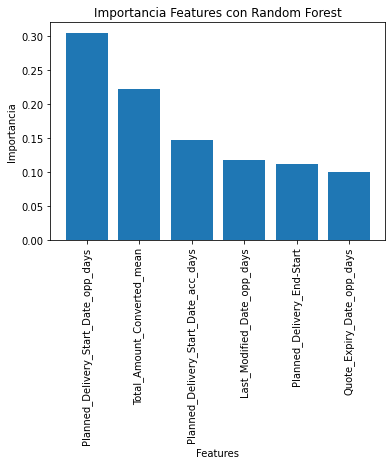

In [25]:
g = p.sort_values('value').nlargest(50, 'value')

plt.bar(g.feature, g.value, )
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con Random Forest')
plt.show()

In [26]:
# Transformo las columnas categoricas con binary encoder

categorical_cols = []

for col in grouped_data.columns:
    if (grouped_data[col].dtype == 'O'):
        categorical_cols.append(col)

print(categorical_cols)

['Region', 'Territory', 'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code', 'Source ', 'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size', 'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date', 'Last_Modified_By', 'ASP_Currency', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency']


In [27]:
for col in categorical_cols:
    print(col)
    print(grouped_data[col].nunique())
    print()

Region
5

Territory
78

Bureaucratic_Code_0_Approval
2

Bureaucratic_Code_0_Approved
2

Bureaucratic_Code
7

Source 
14

Billing_Country
82

Account_Name
1827

Opportunity_Name
11358

Account_Owner
48

Opportunity_Owner
58

Account_Type
7

Opportunity_Type
25

Quote_Type
2

Delivery_Terms
9

Brand
28

Product_Type
7

Size
7

Product_Category_B
29

Price
58

Currency
3

Quote_Expiry_Date
1123

Last_Modified_By
63

ASP_Currency
5

Total_Amount_Currency
5

Total_Taxable_Amount_Currency
5



In [28]:
for col in categorical_cols:
    print(col)
    print(grouped_data[col].value_counts())
    print()

Region
EMEA           3802
Americas       3028
APAC           2337
Japan          2043
Middle East     148
Name: Region, dtype: int64

Territory
None               1959
Germany            1277
NW America         1076
India               774
Japan               681
                   ... 
Mongolia              1
Czech Republic        1
Andorra               1
Monaco                1
Solomon Islands       1
Name: Territory, Length: 78, dtype: int64

Bureaucratic_Code_0_Approval
0    5970
1    5388
Name: Bureaucratic_Code_0_Approval, dtype: int64

Bureaucratic_Code_0_Approved
0    7721
1    3637
Name: Bureaucratic_Code_0_Approved, dtype: int64

Bureaucratic_Code
Bureaucratic_Code_4    8691
Bureaucratic_Code_5    2277
Bureaucratic_Code_1     208
Bureaucratic_Code_2     161
Bureaucratic_Code_0      18
Bureaucratic_Code_3       2
Bureaucratic_Code_6       1
Name: Bureaucratic_Code, dtype: int64

Source 
None         5590
Source_7     2463
Source_9     1067
Source_11     955
Source_13     602

In [29]:
label_enc_cols = ['Region', 'Bureaucratic_Code', 'Delivery_Terms', 'Opportunity_Type', \
                  'Account_Type', 'Last_Modified_By', 'Opportunity_Owner', \
                  'Source ']

In [30]:
merge_train = grouped_data.merge(X, on='Opportunity_ID')
merge_train

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days,Total_Amount_Converted_mean
0,0,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,...,EUR,EUR,EUR,5272800.0,189,54.0,60.0,320,146,5.609362e+06
1,1,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,...,EUR,EUR,EUR,48230.0,39,44.0,2.0,216,42,5.130851e+04
2,2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,...,USD,USD,USD,83865.6,296,297.0,0.0,279,48,8.386560e+04
3,3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,USD,USD,USD,7421881.5,840,52.0,58.0,1650,786,7.421882e+06
4,4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,USD,USD,USD,13357192.5,840,542.0,27.0,1650,786,1.335719e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,EMEA,Norway,1,1,0,0,Bureaucratic_Code_4,2013-07-27,Source_9,...,EUR,EUR,EUR,401700.0,119,121.0,20.0,979,119,7.385810e+03
11354,12800,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,USD,USD,USD,21332500.0,311,42.0,88.0,840,304,4.181760e+04
11355,12801,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,EUR,EUR,EUR,299715.0,46,52.0,4.0,66,108,2.008656e+05
11356,12802,Americas,NE America,1,1,1,1,Bureaucratic_Code_4,2015-10-20,None,...,USD,USD,USD,0.0,48,86.0,4.0,188,142,4.031261e+05


In [31]:
  
def transform_col_days(col):
    values = merge_train.groupby(col)['Planned_Delivery_Start_Date_opp_days'].mean()
    X[col+'_days'] = merge_train.replace({col:values})[col]
    
    
def transform_col_amount(col):
    values = merge_train.groupby(col)['Total_Amount_Converted_mean'].mean()
    X[col+'_amount'] = merge_train.replace({col:values})[col]
    

In [32]:
for c in label_enc_cols: 
    transform_col_days(c)
    transform_col_amount(c)

X

,Opportunity_ID,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days,Total_Amount_Converted_mean,Region_days,Region_amount,Bureaucratic_Code_days,...,Opportunity_Type_days,Opportunity_Type_amount,Account_Type_days,Account_Type_amount,Last_Modified_By_days,Last_Modified_By_amount,Opportunity_Owner_days,Opportunity_Owner_amount,Source _days,Source _amount
0,0,189,54.0,60.0,320,146,5.609362e+06,83.432141,1.226018e+06,68.886894,...,87.724601,5.946322e+05,88.799743,1.026040e+06,66.275000,7.587761e+05,63.555698,1.121455e+06,89.632200,1.120594e+06
1,1,39,44.0,2.0,216,42,5.130851e+04,83.432141,1.226018e+06,68.886894,...,87.724601,5.946322e+05,88.799743,1.026040e+06,123.318182,1.327410e+05,78.380952,2.675057e+05,89.632200,1.120594e+06
2,2,296,297.0,0.0,279,48,8.386560e+04,98.205086,1.555565e+06,68.886894,...,87.724601,5.946322e+05,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,98.953715,1.401714e+06
3,3,840,52.0,58.0,1650,786,7.421882e+06,98.205086,1.555565e+06,151.909091,...,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
4,4,840,542.0,27.0,1650,786,1.335719e+07,98.205086,1.555565e+06,151.909091,...,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,0,28.0,9.0,688,5,9.100000e+04,88.128370,1.252214e+06,68.886894,...,51.850510,4.368914e+05,56.705531,5.673916e+05,65.600805,1.039749e+06,37.729927,9.746688e+04,76.746954,8.309697e+05
1563,12365,1,28.0,91.0,480,158,9.100000e+04,88.128370,1.252214e+06,68.886894,...,51.850510,4.368914e+05,56.705531,5.673916e+05,65.600805,1.039749e+06,37.729927,9.746688e+04,76.746954,8.309697e+05
1564,12366,1,28.0,91.0,480,158,9.511430e+03,88.128370,1.252214e+06,68.886894,...,87.724601,5.946322e+05,88.799743,1.026040e+06,65.600805,1.039749e+06,78.914980,1.081317e+06,109.852941,2.288249e+05
1565,12367,0,30.0,0.0,337,97,3.361835e+04,83.432141,1.226018e+06,68.886894,...,87.724601,5.946322e+05,88.799743,1.026040e+06,65.600805,1.039749e+06,66.692884,6.491445e+05,98.953715,1.401714e+06


In [33]:
train_ids = train.Opportunity_ID.unique()
trainX = X[X['Opportunity_ID'].isin(train_ids)]

y = train.groupby('Opportunity_ID')['Stage'].min()

test_ids = test.Opportunity_ID.unique()
testX = X[X['Opportunity_ID'].isin(test_ids)]

df_train = trainX.drop('Opportunity_ID', axis=1).copy()

In [34]:
# Calculo el error
X_train, X_test, y_train, y_test = \
    train_test_split(df_train, y, test_size=0.2, random_state=123)

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
preds = rf_reg.predict(X_test)
ll = log_loss(y_test, preds, normalize=True)
print("Log Loss: %f" % (ll))

Log Loss: 0.342771


In [35]:
# Feature importances
rf_reg.feature_importances_

array([0.07173232, 0.05641657, 0.08421683, 0.09158839, 0.26210605,
       0.16445626, 0.00634123, 0.00806265, 0.01426305, 0.00942852,
       0.01047904, 0.00913864, 0.01725598, 0.01174076, 0.00724815,
       0.00651428, 0.03327347, 0.02445479, 0.02729345, 0.05711198,
       0.0140223 , 0.01285528])

In [36]:
p = pd.DataFrame({'feature':X_train.columns, 'value':rf_reg.feature_importances_})

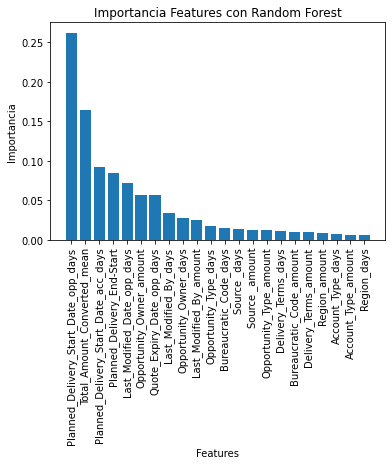

In [37]:
g = p.sort_values('value').nlargest(50, 'value')

plt.bar(g.feature, g.value, )
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con Random Forest')
plt.show()

In [38]:
df_fechas.columns

Index(['Opportunity_ID', 'Last_Modified_Date_opp_days',
       'Quote_Expiry_Date_opp_days', 'Planned_Delivery_End-Start',
       'Planned_Delivery_Start_Date_acc_days',
       'Planned_Delivery_Start_Date_opp_days'],
      dtype='object')

In [39]:
features_anteriores = ['Last_Modified_Date_opp_days', \
       'Quote_Expiry_Date_opp_days', 'Planned_Delivery_End-Start', \
       'Planned_Delivery_Start_Date_acc_days', \
       'Planned_Delivery_Start_Date_opp_days', \
       'Total_Amount_Converted_mean']

In [40]:
X.drop(features_anteriores, axis=1)

,Opportunity_ID,Region_days,Region_amount,Bureaucratic_Code_days,Bureaucratic_Code_amount,Delivery_Terms_days,Delivery_Terms_amount,Opportunity_Type_days,Opportunity_Type_amount,Account_Type_days,Account_Type_amount,Last_Modified_By_days,Last_Modified_By_amount,Opportunity_Owner_days,Opportunity_Owner_amount,Source _days,Source _amount
0,0,83.432141,1.226018e+06,68.886894,8.633106e+05,78.841211,1.007210e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,66.275000,7.587761e+05,63.555698,1.121455e+06,89.632200,1.120594e+06
1,1,83.432141,1.226018e+06,68.886894,8.633106e+05,78.841211,1.007210e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,123.318182,1.327410e+05,78.380952,2.675057e+05,89.632200,1.120594e+06
2,2,98.205086,1.555565e+06,68.886894,8.633106e+05,90.183708,1.052486e+06,87.724601,5.946322e+05,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,98.953715,1.401714e+06
3,3,98.205086,1.555565e+06,151.909091,2.220317e+06,104.112874,1.758935e+06,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
4,4,98.205086,1.555565e+06,151.909091,2.220317e+06,104.112874,1.758935e+06,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,88.128370,1.252214e+06,68.886894,8.633106e+05,104.112874,1.758935e+06,51.850510,4.368914e+05,56.705531,5.673916e+05,65.600805,1.039749e+06,37.729927,9.746688e+04,76.746954,8.309697e+05
1563,12365,88.128370,1.252214e+06,68.886894,8.633106e+05,104.112874,1.758935e+06,51.850510,4.368914e+05,56.705531,5.673916e+05,65.600805,1.039749e+06,37.729927,9.746688e+04,76.746954,8.309697e+05
1564,12366,88.128370,1.252214e+06,68.886894,8.633106e+05,104.112874,1.758935e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,65.600805,1.039749e+06,78.914980,1.081317e+06,109.852941,2.288249e+05
1565,12367,83.432141,1.226018e+06,68.886894,8.633106e+05,78.841211,1.007210e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,65.600805,1.039749e+06,66.692884,6.491445e+05,98.953715,1.401714e+06


In [41]:
import random

s = pd.Series('Random')

for i in range (0, trainX.Opportunity_ID.nunique()):
    s[i] = random.randint(0,10000)
s

0       7360
1       9298
2       2716
3       8415
4       8582
        ... 
9786    7494
9787    6750
9788    6082
9789    6960
9790     314
Length: 9791, dtype: object

In [42]:
df_train2 = df_train.drop(features_anteriores, axis=1)
df_train2['Random'] = s.astype('int64')

In [43]:
# Calculo el error
X_train, X_test, y_train, y_test = \
    train_test_split(df_train2, y, test_size=0.2, random_state=123)

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
preds = rf_reg.predict(X_test)
ll = log_loss(y_test, preds, normalize=True)
print("Log Loss: %f" % (ll))

Log Loss: 0.741525


In [44]:
# Feature importances
rf_reg.feature_importances_

array([0.0126192 , 0.01422863, 0.05560006, 0.00780367, 0.01798332,
       0.02410015, 0.05309889, 0.08562386, 0.02074584, 0.02142648,
       0.05778099, 0.04936714, 0.06085397, 0.10572235, 0.03083884,
       0.03739043, 0.34481616])

In [45]:
p = pd.DataFrame({'feature':X_train.columns, 'value':rf_reg.feature_importances_})

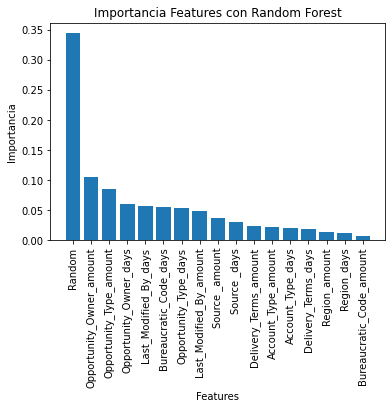

In [46]:
g = p.sort_values('value').nlargest(50, 'value')

plt.bar(g.feature, g.value, )
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con Random Forest')
plt.show()

In [71]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
transformed_train = sc.fit_transform(df_train2)


In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Me fijo cuantos features son mejores que el random
model = LogisticRegression()

for nfeatures in range(10,18):
    rfe = RFE(model, n_features_to_select=nfeatures)
    rfe = rfe.fit(transformed_train, y)
    
    print('Optimal features: %i' %nfeatures)
    print('Selected features: %s' % list(df_train2.columns[rfe.support_]))
    print()

Optimal features: 10
Selected features: ['Region_days', 'Region_amount', 'Bureaucratic_Code_days', 'Bureaucratic_Code_amount', 'Opportunity_Type_days', 'Account_Type_days', 'Account_Type_amount', 'Last_Modified_By_days', 'Opportunity_Owner_days', 'Opportunity_Owner_amount']

Optimal features: 11
Selected features: ['Region_days', 'Region_amount', 'Bureaucratic_Code_days', 'Bureaucratic_Code_amount', 'Opportunity_Type_days', 'Account_Type_days', 'Account_Type_amount', 'Last_Modified_By_days', 'Opportunity_Owner_days', 'Opportunity_Owner_amount', 'Source _days']

Optimal features: 12
Selected features: ['Region_days', 'Region_amount', 'Bureaucratic_Code_days', 'Bureaucratic_Code_amount', 'Delivery_Terms_amount', 'Opportunity_Type_days', 'Account_Type_days', 'Account_Type_amount', 'Last_Modified_By_days', 'Opportunity_Owner_days', 'Opportunity_Owner_amount', 'Source _days']

Optimal features: 13
Selected features: ['Region_days', 'Region_amount', 'Bureaucratic_Code_days', 'Bureaucratic_Co

In [98]:
# Solo aparecio el feature random al utilizar todos los features anteriores

In [82]:
trainX.drop(features_anteriores, axis=1)\
.to_csv('../files_csv/train_mean_days.csv')

In [83]:
testX.drop(features_anteriores, axis=1)\
.to_csv('../files_csv/test_mean_days.csv')

In [101]:
encoder = ce.BinaryEncoder(cols = ['Region','Territory','Bureaucratic_Code',\
                                    'Account_Type','Billing_Country'],\
                           drop_invariant = True)
X2 = encoder.fit_transform(grouped_data[['Opportunity_ID','Region','Territory',\
                                         'Bureaucratic_Code',\
                                         'Account_Type','Billing_Country']])

X2

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Opportunity_ID,Region_1,Region_2,Region_3,Territory_1,Territory_2,Territory_3,Territory_4,Territory_5,Territory_6,...,Account_Type_1,Account_Type_2,Account_Type_3,Billing_Country_1,Billing_Country_2,Billing_Country_3,Billing_Country_4,Billing_Country_5,Billing_Country_6,Billing_Country_7
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,2,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,3,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,4,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,0,0,1,0,0,1,1,0,0,...,0,1,1,0,0,0,0,1,1,1
11354,12800,0,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,1,1
11355,12801,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,1,1,0,0
11356,12802,0,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0


In [108]:
train_ids = train.Opportunity_ID.unique()
trainX = X2[X2['Opportunity_ID'].isin(train_ids)]

y = train.groupby('Opportunity_ID')['Stage'].min()

test_ids = test.Opportunity_ID.unique()
testX = X2[X2['Opportunity_ID'].isin(test_ids)]

df_train = trainX.drop('Opportunity_ID', axis=1).copy()

In [111]:
trainX.to_csv('../files_csv/train_binary_enc_7_cols.csv', index=False)

In [112]:
testX.to_csv('../files_csv/test_binary_enc_7_cols.csv', index=False)

In [119]:
grouped_train = train.groupby('Opportunity_ID').agg(\
                        {'Source ':'first', \
                         'Opportunity_Owner':'first', \
                         'Delivery_Terms':'first', \
                         'Opportunity_Type':'first', \
                         'Account_Name':'first', \
                         'Last_Modified_By':'first'})

grouped_test = test.groupby('Opportunity_ID').agg(\
                        {'Source ':'first', \
                         'Opportunity_Owner':'first', \
                         'Delivery_Terms':'first', \
                         'Opportunity_Type':'first', \
                         'Account_Name':'first', \
                         'Last_Modified_By':'first'})

In [120]:
grouped_train['Source '].value_counts().describe()

count      14.000000
mean      699.357143
std      1331.205504
min         1.000000
25%        20.750000
50%        88.500000
75%       768.500000
max      4874.000000
Name: Source , dtype: float64

In [121]:
grouped_train['Opportunity_Owner'].value_counts().describe()

count     53.000000
mean     184.735849
std      227.892362
min        1.000000
25%       31.000000
50%      103.000000
75%      193.000000
max      951.000000
Name: Opportunity_Owner, dtype: float64

In [122]:
grouped_train['Delivery_Terms'].value_counts().describe()

count       9.000000
mean     1087.888889
std      1414.006581
min         4.000000
25%        36.000000
50%       434.000000
75%      1985.000000
max      3446.000000
Name: Delivery_Terms, dtype: float64

In [123]:
grouped_train['Opportunity_Type'].value_counts().describe()

count      25.000000
mean      391.640000
std      1093.335603
min         1.000000
25%         4.000000
50%        10.000000
75%       135.000000
max      5128.000000
Name: Opportunity_Type, dtype: float64

In [121]:
grouped_train['Account_Name'].value_counts().describe()

count     53.000000
mean     184.735849
std      227.892362
min        1.000000
25%       31.000000
50%      103.000000
75%      193.000000
max      951.000000
Name: Opportunity_Owner, dtype: float64

In [121]:
grouped_train['Last_Modified_By'].value_counts().describe()

count     53.000000
mean     184.735849
std      227.892362
min        1.000000
25%       31.000000
50%      103.000000
75%      193.000000
max      951.000000
Name: Opportunity_Owner, dtype: float64

In [118]:
data.Opportunity_Owner.value_counts().describe()

count      58.000000
mean      335.068966
std       589.894129
min         1.000000
25%        44.500000
50%       145.000000
75%       322.500000
max      3837.000000
Name: Opportunity_Owner, dtype: float64

In [130]:
target_enc_cols = ['Source ', 'Opportunity_Owner', 'Delivery_Terms',\
                   'Opportunity_Type', 'Account_Name', 'Last_Modified_By']

target_enc = ce.TargetEncoder(cols = target_enc_cols, min_samples_leaf = 30,\
                              smoothing = 0.1)

target_enc.fit(grouped_train, y)
# Must pass the series for y in v1.2.

X3 = target_enc.transform(grouped_train, y)
X3

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Source,Opportunity_Owner,Delivery_Terms,Opportunity_Type,Account_Name,Last_Modified_By
Opportunity_ID,,,,,,
0,0.513541,0.482405,0.479801,0.520281,0.553191,0.381579
1,0.513541,0.690476,0.479801,0.520281,0.553191,0.518027
2,0.440136,0.562254,0.547011,0.520281,0.822785,0.437984
3,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
4,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
...,...,...,...,...,...,...
12799,0.557979,0.574074,0.479801,0.520281,0.587571,0.521978
12800,0.513541,0.574074,0.547011,0.158183,0.518027,0.521978
12801,0.440136,0.574074,0.479801,0.520281,0.518027,0.521978


In [152]:
kf = KFold(n_splits=5, shuffle=True)

for samples_leaf in [30, 50, 100]:
    for smooth in [0.1,0.2,0.3, 0.4]: 

        target_enc = ce.TargetEncoder(cols = target_enc_cols, min_samples_leaf = samples_leaf,\
                                      smoothing = smooth)
        target_enc.fit(grouped_train, y)
        X4 = target_enc.transform(grouped_train, y)

        errores = []
        for train_index, test_index in kf.split(X4):
            X_train, X_test = X4.iloc[train_index], X4.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            rf_model = RandomForestRegressor(random_state=1, n_estimators=50)
            rf_model.fit(X_train, y_train)
            preds = rf_model.predict(X_test)

            loss = np.sqrt(log_loss(y_test, preds))
            errores.append(loss)

        print('Min sample leaf: %i' % samples_leaf)
        print('Smoothing: %f' % smooth)
        print("Log loss: %f" % (statistics.mean(errores)))

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 30
Smoothing: 0.100000
Log loss: 0.914356


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 30
Smoothing: 0.200000
Log loss: 0.921488


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 30
Smoothing: 0.300000
Log loss: 0.914910


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 30
Smoothing: 0.400000
Log loss: 0.900112


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 50
Smoothing: 0.100000
Log loss: 0.904107


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 50
Smoothing: 0.200000
Log loss: 0.876469


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 50
Smoothing: 0.300000
Log loss: 0.892333


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 50
Smoothing: 0.400000
Log loss: 0.902976


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/cecilia/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cecilia/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cecilia/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cecilia/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cecilia/.local/lib/python3.6/site-packages/pandas/core/series

Min sample leaf: 100
Smoothing: 0.100000
Log loss: 0.874325


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 100
Smoothing: 0.200000
Log loss: 0.877572


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 100
Smoothing: 0.300000
Log loss: 0.882255


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Min sample leaf: 100
Smoothing: 0.400000
Log loss: 0.878019


In [154]:
target_enc = ce.TargetEncoder(cols = target_enc_cols, min_samples_leaf = 50,\
                              smoothing = 0.2)

target_enc.fit(grouped_train, y)

X3 = target_enc.transform(grouped_train, y).reset_index()
X3

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Opportunity_ID,Source,Opportunity_Owner,Delivery_Terms,Opportunity_Type,Account_Name,Last_Modified_By
0,0,0.513541,0.482405,0.479801,0.520281,0.518027,0.381579
1,1,0.513541,0.518027,0.479801,0.520281,0.518027,0.518027
2,2,0.440136,0.562254,0.547011,0.520281,0.822785,0.437984
3,3,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
4,4,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
...,...,...,...,...,...,...,...
9786,12799,0.557979,0.574074,0.479801,0.520281,0.587571,0.521978
9787,12800,0.513541,0.574074,0.547011,0.158183,0.518027,0.521978
9788,12801,0.440136,0.574074,0.479801,0.520281,0.518027,0.521978
9789,12802,0.513541,0.285467,0.547011,0.520281,0.518027,0.152344


In [155]:
test_X3 = target_enc.transform(grouped_test).reset_index()
test_X3

,Opportunity_ID,Source,Opportunity_Owner,Delivery_Terms,Opportunity_Type,Account_Name,Last_Modified_By
0,10689,0.440136,0.574074,0.479801,0.702041,0.518027,0.521978
1,10690,0.440136,0.574074,0.479801,0.702041,0.518027,0.521978
2,10691,0.557979,0.518027,0.547011,0.688221,0.518027,0.518027
3,10692,0.632822,0.562254,0.547011,0.520281,0.780282,0.437984
4,10693,0.557979,0.681416,0.547011,0.688221,0.518027,0.693333
...,...,...,...,...,...,...,...
1562,12364,0.526490,0.574074,0.518027,0.520281,0.518027,0.521978
1563,12365,0.513541,0.349693,0.547011,0.520281,0.518027,0.333333
1564,12366,0.513541,0.349693,0.547011,0.520281,0.518027,0.333333
1565,12367,0.513541,0.518027,0.547011,0.688221,0.518027,0.518027


In [156]:
X3.to_csv('../files_csv/train_target_enc_7_cols.csv', index=False)

In [157]:
test_X3.to_csv('../files_csv/test_target_enc_7_cols.csv', index=False)

In [159]:
categorical_cols

['Region',
 'Territory',
 'Bureaucratic_Code_0_Approval',
 'Bureaucratic_Code_0_Approved',
 'Bureaucratic_Code',
 'Source ',
 'Billing_Country',
 'Account_Name',
 'Opportunity_Name',
 'Account_Owner',
 'Opportunity_Owner',
 'Account_Type',
 'Opportunity_Type',
 'Quote_Type',
 'Delivery_Terms',
 'Brand',
 'Product_Type',
 'Size',
 'Product_Category_B',
 'Price',
 'Currency',
 'Quote_Expiry_Date',
 'Last_Modified_By',
 'ASP_Currency',
 'Total_Amount_Currency',
 'Total_Taxable_Amount_Currency']

In [ ]:
grouped_train_2 = train.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Source ':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first'}).reset_index()

In [161]:
grouped_test_2 = test.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Source ':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first'}).reset_index()

In [162]:
# Random permutation 
perm = np.random.permutation(len(grouped_train_2)) 
grouped_train_perm = grouped_train_2.iloc[perm].reset_index(drop=True)
y = y.iloc[perm].reset_index(drop=True)

In [163]:
grouped_train_perm

,Opportunity_ID,Region,Territory,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_Name,...,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency
0,1728,Americas,NE America,1,1,Bureaucratic_Code_4,None,United States,Account_Name_1734,Opportunity_Name_11276,...,None,None,None,None,None,2/3/2017,Person_Name_47,USD,USD,USD
1,6602,APAC,Indonesia,0,0,Bureaucratic_Code_4,Source_7,Indonesia,Account_Name_1903,Opportunity_Name_2205,...,None,None,None,None,None,12/13/2017,Person_Name_47,USD,USD,USD
2,5728,Americas,NE America,0,0,Bureaucratic_Code_4,None,United States,Account_Name_815,Opportunity_Name_5335,...,None,None,None,None,None,8/31/2017,Person_Name_47,USD,USD,USD
3,10291,Japan,None,0,0,Bureaucratic_Code_4,None,Japan,Account_Name_1508,Opportunity_Name_279,...,None,None,None,None,None,11/21/2018,Person_Name_50,JPY,JPY,JPY
4,3658,EMEA,France,0,0,Bureaucratic_Code_4,None,France,Account_Name_1495,Opportunity_Name_12848,...,None,None,None,None,None,5/2/2017,Person_Name_47,EUR,EUR,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,6635,Japan,None,0,0,Bureaucratic_Code_4,None,Japan,Account_Name_1836,Opportunity_Name_6583,...,None,None,None,None,None,9/28/2017,Person_Name_47,JPY,JPY,JPY
9787,1696,Japan,None,1,1,Bureaucratic_Code_4,None,None,Account_Name_1287,Opportunity_Name_8873,...,None,None,None,None,None,5/31/2016,Person_Name_66,USD,USD,USD
9788,12482,EMEA,Sweden,0,0,Bureaucratic_Code_4,Source_7,Germany,Account_Name_263,Opportunity_Name_9302,...,None,None,None,None,None,3/31/2016,Person_Name_13,EUR,EUR,EUR
9789,470,APAC,Singapore,0,0,Bureaucratic_Code_4,None,Singapore,Account_Name_432,Opportunity_Name_791,...,None,None,None,None,None,2/28/2017,Person_Name_47,USD,USD,USD


In [166]:
cat_encoder = ce.cat_boost.CatBoostEncoder(verbose=1, cols=categorical_cols, \
drop_invariant=True)

cat_encoder.fit(grouped_train_perm, y)

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CatBoostEncoder(cols=['Region', 'Territory', 'Bureaucratic_Code_0_Approval',
                      'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code',
                      'Source ', 'Billing_Country', 'Account_Name',
                      'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner',
                      'Account_Type', 'Opportunity_Type', 'Quote_Type',
                      'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
                      'Product_Category_B', 'Price', 'Currency',
                      'Quote_Expiry_Date', 'Last_Modified_By', 'ASP_Currency',
                      'Total_Amount_Currency',
                      'Total_Taxable_Amount_Currency'],
                drop_invariant=True, verbose=1)

In [183]:
X4 = cat_encoder.transform(grouped_train_perm, y)
X4

,Opportunity_ID,Region,Territory,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_Name,...,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency
0,1728,0.480702,0.600715,0.411947,0.534351,0.515197,0.624896,0.528679,0.514973,0.481305,...,0.575386,0.609072,0.508450,0.501082,0.415330,0.457237,0.572171,0.564953,0.549953,0.539313
1,6602,0.575207,0.534146,0.563525,0.427267,0.264248,0.438181,0.577057,0.589803,0.541651,...,0.245360,0.301828,0.188614,0.284408,0.243191,0.666134,0.315871,0.258236,0.249257,0.292573
2,5728,0.223371,0.265639,0.673842,0.749182,0.515189,0.252166,0.293835,0.528955,0.530661,...,0.452362,0.525502,0.467169,0.506815,0.492419,0.549537,0.520991,0.582573,0.502026,0.503066
3,10291,0.513076,0.565437,0.527130,0.494338,0.397038,0.178843,0.488435,0.514979,0.582831,...,0.312189,0.348493,0.339341,0.319582,0.369655,0.563282,0.482802,0.560397,0.489310,0.484032
4,3658,0.496674,0.466006,0.530265,0.699601,0.606392,0.408599,0.594223,0.453263,0.462138,...,0.543583,0.528482,0.462064,0.482048,0.495972,0.478960,0.346146,0.479151,0.564868,0.531540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,6635,0.633601,0.518098,0.631159,0.565457,0.590176,0.503192,0.612906,0.824728,0.495128,...,0.548412,0.471552,0.601197,0.661473,0.509778,0.762243,0.604566,0.588596,0.787729,0.633085
9787,1696,0.589544,0.556240,0.420263,0.506953,0.675000,0.478749,0.018513,0.315456,0.455603,...,0.512439,0.652612,0.584119,0.550072,0.503335,0.703879,0.497557,0.437467,0.492890,0.430887
9788,12482,0.405443,0.464488,0.682180,0.516470,0.664244,0.405016,0.506524,0.902239,0.548279,...,0.646188,0.606631,0.606744,0.548528,0.506062,0.555496,0.594871,0.440824,0.445278,0.542509
9789,470,0.608819,0.882326,0.542797,0.492165,0.555190,0.520936,0.624780,0.607151,0.592517,...,0.645987,0.522315,0.545673,0.523916,0.561079,0.449023,0.592138,0.498831,0.462901,0.464854


In [184]:
# Calculo el error
X_train, X_test, y_train, y_test = \
    train_test_split(X4.drop('Opportunity_ID', axis=1), y, test_size=0.2, random_state=123)

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
preds = rf_reg.predict(X_test)
ll = log_loss(y_test, preds, normalize=True)
print("Log Loss: %f" % (ll))

Log Loss: 0.472977


In [178]:
kf = KFold(n_splits=5, shuffle=True)

for s in [0,0.1,0.3,0.5,0.8,1]:
    cat_encoder = ce.cat_boost.CatBoostEncoder(cols=categorical_cols, sigma=s,\
            drop_invariant=True)

    cat_encoder.fit(grouped_train_perm, y)
    X5 = cat_encoder.transform(grouped_train_perm)

    errores = []
    for train_index, test_index in kf.split(X5):
            X_train, X_test = X5.iloc[train_index], X5.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            rf_model = RandomForestRegressor(random_state=1, n_estimators=50)
            rf_model.fit(X_train, y_train)
            preds = rf_model.predict(X_test)

            loss = np.sqrt(log_loss(y_test, preds))
            errores.append(loss)

    print('Sigma: %f' % s)
    print("Log loss: %f" % (statistics.mean(errores)))

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Sigma: 0.000000
Log loss: 0.676719


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Sigma: 0.100000
Log loss: 0.699396


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Sigma: 0.300000
Log loss: 0.705941


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Sigma: 0.500000
Log loss: 0.677234


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Sigma: 0.800000
Log loss: 0.676751


/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Sigma: 1.000000
Log loss: 0.699670


In [185]:
cat_encoder = ce.cat_boost.CatBoostEncoder(cols=categorical_cols, sigma=0.1, \
drop_invariant=True)

cat_encoder.fit(grouped_train_perm, y)

/home/cecilia/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CatBoostEncoder(cols=['Region', 'Territory', 'Bureaucratic_Code_0_Approval',
                      'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code',
                      'Source ', 'Billing_Country', 'Account_Name',
                      'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner',
                      'Account_Type', 'Opportunity_Type', 'Quote_Type',
                      'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
                      'Product_Category_B', 'Price', 'Currency',
                      'Quote_Expiry_Date', 'Last_Modified_By', 'ASP_Currency',
                      'Total_Amount_Currency',
                      'Total_Taxable_Amount_Currency'],
                drop_invariant=True, sigma=0.1)

In [186]:
train_X4 = cat_encoder.transform(grouped_train_perm,y).sort_values('Opportunity_ID')
train_X4

,Opportunity_ID,Region,Territory,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_Name,...,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency
1275,0,0.504556,0.618947,0.415276,0.436083,0.588886,0.475482,0.479551,0.551375,0.452898,...,0.563817,0.604471,0.494060,0.618610,0.522716,0.132937,0.316337,0.445631,0.583160,0.542879
1180,1,0.523115,0.521325,0.604962,0.464447,0.585918,0.509219,0.594602,0.520764,0.497335,...,0.554836,0.628808,0.496615,0.504029,0.545301,0.541291,0.672297,0.472581,0.390932,0.441528
3514,2,0.468367,0.713799,0.454188,0.423713,0.539575,0.459604,0.536891,0.807842,0.496299,...,0.496769,0.566104,0.467738,0.504514,0.556729,0.887222,0.462798,0.492280,0.466973,0.422812
1324,3,0.407498,0.587917,0.394974,0.492367,0.228532,0.637074,0.433497,0.254328,0.469851,...,0.037384,0.017035,0.179622,0.549715,0.011188,0.322723,0.377569,0.511753,0.541772,0.471926
3556,4,0.499265,0.622668,0.330164,0.480089,0.242223,0.643448,0.569161,0.131504,0.486388,...,0.018939,0.008988,0.086680,0.125472,0.004865,0.668401,0.494510,0.452361,0.426220,0.481163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,12799,0.504328,0.443608,0.646657,0.491598,0.721153,0.425386,0.452780,0.719542,0.569236,...,0.522856,0.530759,0.552062,0.484153,0.496210,0.538871,0.569606,0.510169,0.424257,0.372836
6102,12800,0.383716,0.328255,0.745268,0.568134,0.233129,0.454412,0.463755,0.059841,0.503785,...,0.567073,0.603460,0.694418,0.598891,0.494163,0.582515,0.631222,0.487350,0.524343,0.533946
3827,12801,0.482562,0.809596,0.468741,0.568852,0.567130,0.489779,0.725695,0.536095,0.504769,...,0.489712,0.611131,0.597381,0.413741,0.589768,0.281546,0.470625,0.554071,0.451781,0.429288
4881,12802,0.438178,0.374651,0.425166,0.459351,0.669739,0.507044,0.541116,0.510113,0.563802,...,0.540427,0.478419,0.631559,0.490078,0.489124,0.230108,0.156457,0.483331,0.490883,0.506112


In [188]:
test_X4 = cat_encoder.transform(grouped_test_2)
test_X4

,Opportunity_ID,Region,Territory,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_Name,...,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency
0,10689,0.463409,0.548120,0.409606,0.487453,0.595665,0.440173,0.513021,0.430652,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.521967,0.471338,0.471338,0.469853
1,10690,0.463409,0.548120,0.409606,0.487453,0.595665,0.440173,0.513021,0.430652,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.521967,0.471338,0.471338,0.469853
2,10691,0.446196,0.347819,0.625895,0.533608,0.595665,0.557934,0.452013,0.518027,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.345864,0.518027,0.463713,0.463713,0.464785
3,10692,0.446196,0.632592,0.409606,0.533608,0.285273,0.632686,0.452013,0.779545,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.345864,0.438294,0.463713,0.463713,0.464785
4,10693,0.446196,0.632592,0.625895,0.533608,0.595665,0.557934,0.452013,0.922001,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.692172,0.463713,0.463713,0.464785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,0.463409,0.424464,0.625895,0.533608,0.595665,0.526462,0.543169,0.592548,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.521967,0.463713,0.463713,0.464785
1563,12365,0.446196,0.368397,0.625895,0.533608,0.595665,0.513542,0.452013,0.379507,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.335972,0.463713,0.463713,0.464785
1564,12366,0.446196,0.368397,0.409606,0.487453,0.595665,0.513542,0.452013,0.379507,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.335972,0.463713,0.463713,0.464785
1565,12367,0.446196,0.347819,0.625895,0.533608,0.595665,0.513542,0.452013,0.518027,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.518027,0.463713,0.463713,0.464785


In [189]:
train_X4.to_csv('../files_csv/train_cat_enc_26_cols.csv', index=False)

In [191]:
test_X4.to_csv('../files_csv/test_cat_enc_26_cols.csv', index=False)